# Numerical Scientific Computing Miniproject 1

### Setting up packages and parameters

In [132]:
import timeit
from numba import jit
import dask.array as desk
import multiprocessing as mp
import numpy as numerinopyndarino
import matplotlib.pyplot as ploterino
from dask.distributed import Client, wait

In [133]:
#Parameters
pim = 500
pre = 500
I = 100
T = 2

### Declare different datatypes for testing

The three types are

csingle     | float complex       | Complex number, represented by two single-precision floats (real and imaginary components).

cdouble     | double complex      | Complex number, represented by two double-precision floats (real and imaginary components).

clongdouble | long double complex | Complex number, represented by two extended-precision floats (real and imaginary components).

The main difference between them is that in float we can store values upto 4 bytes (6 places after decimal point). Double upto 8 bytes, and long double even more than float and double.

In [54]:

dtypes = [numerinopyndarino.csingle, numerinopyndarino.cdouble, numerinopyndarino.clongdouble]
print(dtypes)

[<class 'numpy.complex64'>, <class 'numpy.complex128'>, <class 'numpy.complex256'>]


### Generate the complex matrix C

A function is declared that generates the complex matrix C with a given dataype.

In [111]:
def generate_complex_c(pim, pre, dtype):
    C = numerinopyndarino.zeros((pim, pre), dtype=dtype) #Generate the C matrix with the given dimesion pim x pre
    re = numerinopyndarino.tile(numerinopyndarino.linspace(-2, 1, pim, dtype=dtype),(pim,1)) #Generate real numbers from -2 to 1, with pim intervals (Stored in a pim x pim matrix)
    im = numerinopyndarino.tile(numerinopyndarino.linspace(1.5, -1.5, pre, dtype=dtype), (pre,1)).T #Generate imaginary numbers from -1.5 to 1.5 with pre intervals (Stored in a pre x pre matrix)
    C = re + im*1j
    return C

### Testing the speed of different datatypes

This section tests the datatypes on the previously implemented methods: Naive and Vectorized.

First, we declare a function for each method:

In [63]:
#Naive
def naive(C, I, T):
    M = numerinopyndarino.zeros(C.shape) #Declare our output matrix M

    for row in range(C.shape[0]):  #Loop through each complex number c in our C matrix
        for col in range(C.shape[1]):

            c = C[row, col]
            z = 0 + 0j

            for i in range(I-1): #Calculate I iterations of z with formula: z_(i+1) = z_i ^2 + c
                
                z = (z**2) + c

                if (numerinopyndarino.abs(z) > T): #Calculate l(c) as the index where |z_i| > T
                    lc = i
                    break
                else:
                    lc = I

            M[row, col] = lc/I #Store lc to the output matrix M. We divide by I to map from 0-1.
    return M

In [64]:
#Vectorized
def vectorized(C, I, T, dtype):
    M = numerinopyndarino.zeros(C.shape, dtype=int) #Declare our output matrix M

    Z = numerinopyndarino.zeros(C.shape, dtype=dtype) #Declare Z as a matrix, where we calculate z = z²+c for each point in C

    for i in range(I-1):
        Z = Z*Z + C

        M[numerinopyndarino.abs(Z) > T] = i

    M[numerinopyndarino.abs(Z) <= T] = I

    return M

Timeit is used to measure the time for each datatype

In [112]:
#The results are stored in these lists
naive_results = []
vectorized_results = []
print("---------")
#NAIVE
for dtype in dtypes: #Loop all the datatypes
    C = generate_complex_c(pim, pre, dtype) #Generate the complex matrix with the given datatype
    #NAIVE
    print("Naive Implementation with the datatype: ", dtype)
    naive_result = timeit.Timer(lambda: naive(C, I, T)).timeit(5) #Calculate the time for the naive implementation
    naive_results.append(naive_result)
    print("Time: ", naive_result)

    print("---------")

#VECTORIZED
for dtype in dtypes: #Loop all the datatypes
    C = generate_complex_c(pim, pre, dtype) #Generate the complex matrix with the given datatype
    #VECTORIZED
    print("Vectorized Implementation with the datatype: ", dtype)
    vectorized_result = timeit.Timer(lambda: vectorized(C, I, T, dtype)).timeit(5) #Calculate the time for the vectorized implementation
    vectorized_results.append(vectorized_result)
    print("Time: ", vectorized_result)   

    print("----------")

---------
Naive Implementation with the datatype:  <class 'numpy.complex64'>
Time:  36.044756290037185
---------
Naive Implementation with the datatype:  <class 'numpy.complex128'>
Time:  31.588780764956027
---------
Naive Implementation with the datatype:  <class 'numpy.complex256'>
Time:  34.626312197884545
---------
Vectorized Implementation with the datatype:  <class 'numpy.complex64'>


/tmp/ipykernel_1309251/4180854526.py:8: RuntimeWarning: overflow encountered in multiply
  Z = Z*Z + C
/tmp/ipykernel_1309251/4180854526.py:8: RuntimeWarning: invalid value encountered in multiply
  Z = Z*Z + C
/tmp/ipykernel_1309251/4180854526.py:10: RuntimeWarning: overflow encountered in absolute
  M[numerinopyndarino.abs(Z) > T] = i


Time:  0.9499982940033078
----------
Vectorized Implementation with the datatype:  <class 'numpy.complex128'>
Time:  1.741845262935385
----------
Vectorized Implementation with the datatype:  <class 'numpy.complex256'>
Time:  10.259832598036155
----------


##### Time for Multiprocessing Implementation | A set of cores and chunk size are tested

In [16]:
P = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20] #List containing number of cores
chunks = (2, 4, 8, 16, 32, 64, 128) #List containing chunk sizes
all_t_multiprocessing = [] #List of processing times for each combination of P and chunks

t_multiprocessing = 10000 #Temp time for best multiprocessing time
p_best = 0 #Best processer
c_best = 0 #Best chunk size

for p in P:
    for c in chunks:
        print("Multiprocessing Implementation. Cores: ", p, " | Chunks: ", c)
        t  = timeit.Timer(lambda: naive_with_multiprocessing(C, I, T, p, c)).timeit(5)
        print("Time: ",  t)
        #Check if new time is the best so far
        all_t_multiprocessing.append(t)
        if t <= t_multiprocessing:
            p_best = p
            c_best = c
            t_multiprocessing = t
print("Best time: ", t_multiprocessing, " | Processes: ", p_best, " | Chunks: ", c_best)

Multiprocessing Implementation. Cores:  1  | Chunks:  2
Time:  35.89899236099154
Multiprocessing Implementation. Cores:  1  | Chunks:  4
Time:  35.48121941600402
Multiprocessing Implementation. Cores:  1  | Chunks:  8
Time:  35.02345437000622
Multiprocessing Implementation. Cores:  1  | Chunks:  16
Time:  38.43580287999066
Multiprocessing Implementation. Cores:  1  | Chunks:  32
Time:  35.304097038999316
Multiprocessing Implementation. Cores:  1  | Chunks:  64
Time:  33.63216339200153
Multiprocessing Implementation. Cores:  1  | Chunks:  128
Time:  33.82597499201074
Multiprocessing Implementation. Cores:  2  | Chunks:  2
Time:  20.941224410998984
Multiprocessing Implementation. Cores:  2  | Chunks:  4
Time:  21.734367911994923
Multiprocessing Implementation. Cores:  2  | Chunks:  8
Time:  21.828383072002907
Multiprocessing Implementation. Cores:  2  | Chunks:  16
Time:  17.644110074004857
Multiprocessing Implementation. Cores:  2  | Chunks:  32
Time:  18.05313987500267
Multiprocessing 

The best time for multiprocessing is 3.4 seconds with 12 processes and 128 chunks!

### Plot the processing times

The times are plotted using matplotlib

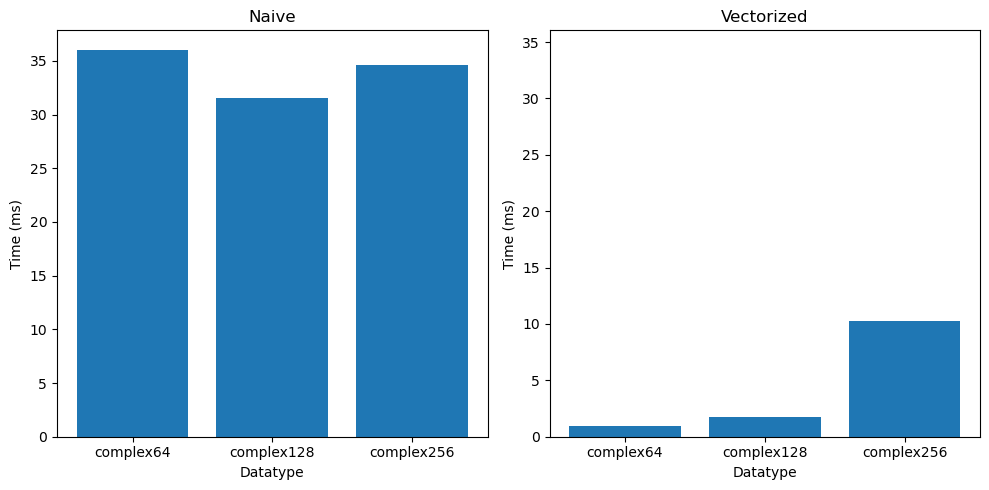

In [113]:
fig = ploterino.figure(figsize=(10, 5))
ax = fig.subplots(1, 2)

ax[0].bar(['complex64', 'complex128', 'complex256'], naive_results)
ax[0].set_title('Naive')
ax[0].set_ylabel('Time (ms)')
ax[0].set_xlabel('Datatype')

ax[1].bar(['complex64', 'complex128', 'complex256'], vectorized_results)
ax[1].set_title('Vectorized')
ax[1].set_ylabel('Time (ms)')
ax[1].set_xlabel('Datatype')
ax[1].set_ylim(0, max(naive_results))

fig.tight_layout()

ploterino.show()


The naive method improves when the datatype has more bytes to store the precision.

The vectorized method is the complete opposite, and gets worse with an increase in the amount of bytes.

#### Time for some dask!

We define a function to use the naive implementation with dask - and with multiprocessing!

In [151]:
def naive_with_dask(C, P, chunk_size):
    client = Client(n_workers=P)

    data = C.map_blocks(lambda x: naive(x, I, T), chunks=chunk_size).compute()

    client.close()

    return data

Timeit to measure the time for the dask implementation

In [ ]:
#Generate the C matrix and convert it to a dask array
C = generate_complex_c(pim, pre, dtypes[0])
C_dask = desk.from_array(C, chunks='auto')

P = 8
chunk_size = (10, 10)

dask_result = timeit.Timer(lambda: naive_with_dask(C, P, chunk_size)).timeit(5) #Calculate the time for the vectorized implementation
print("Res: ", dask_result)

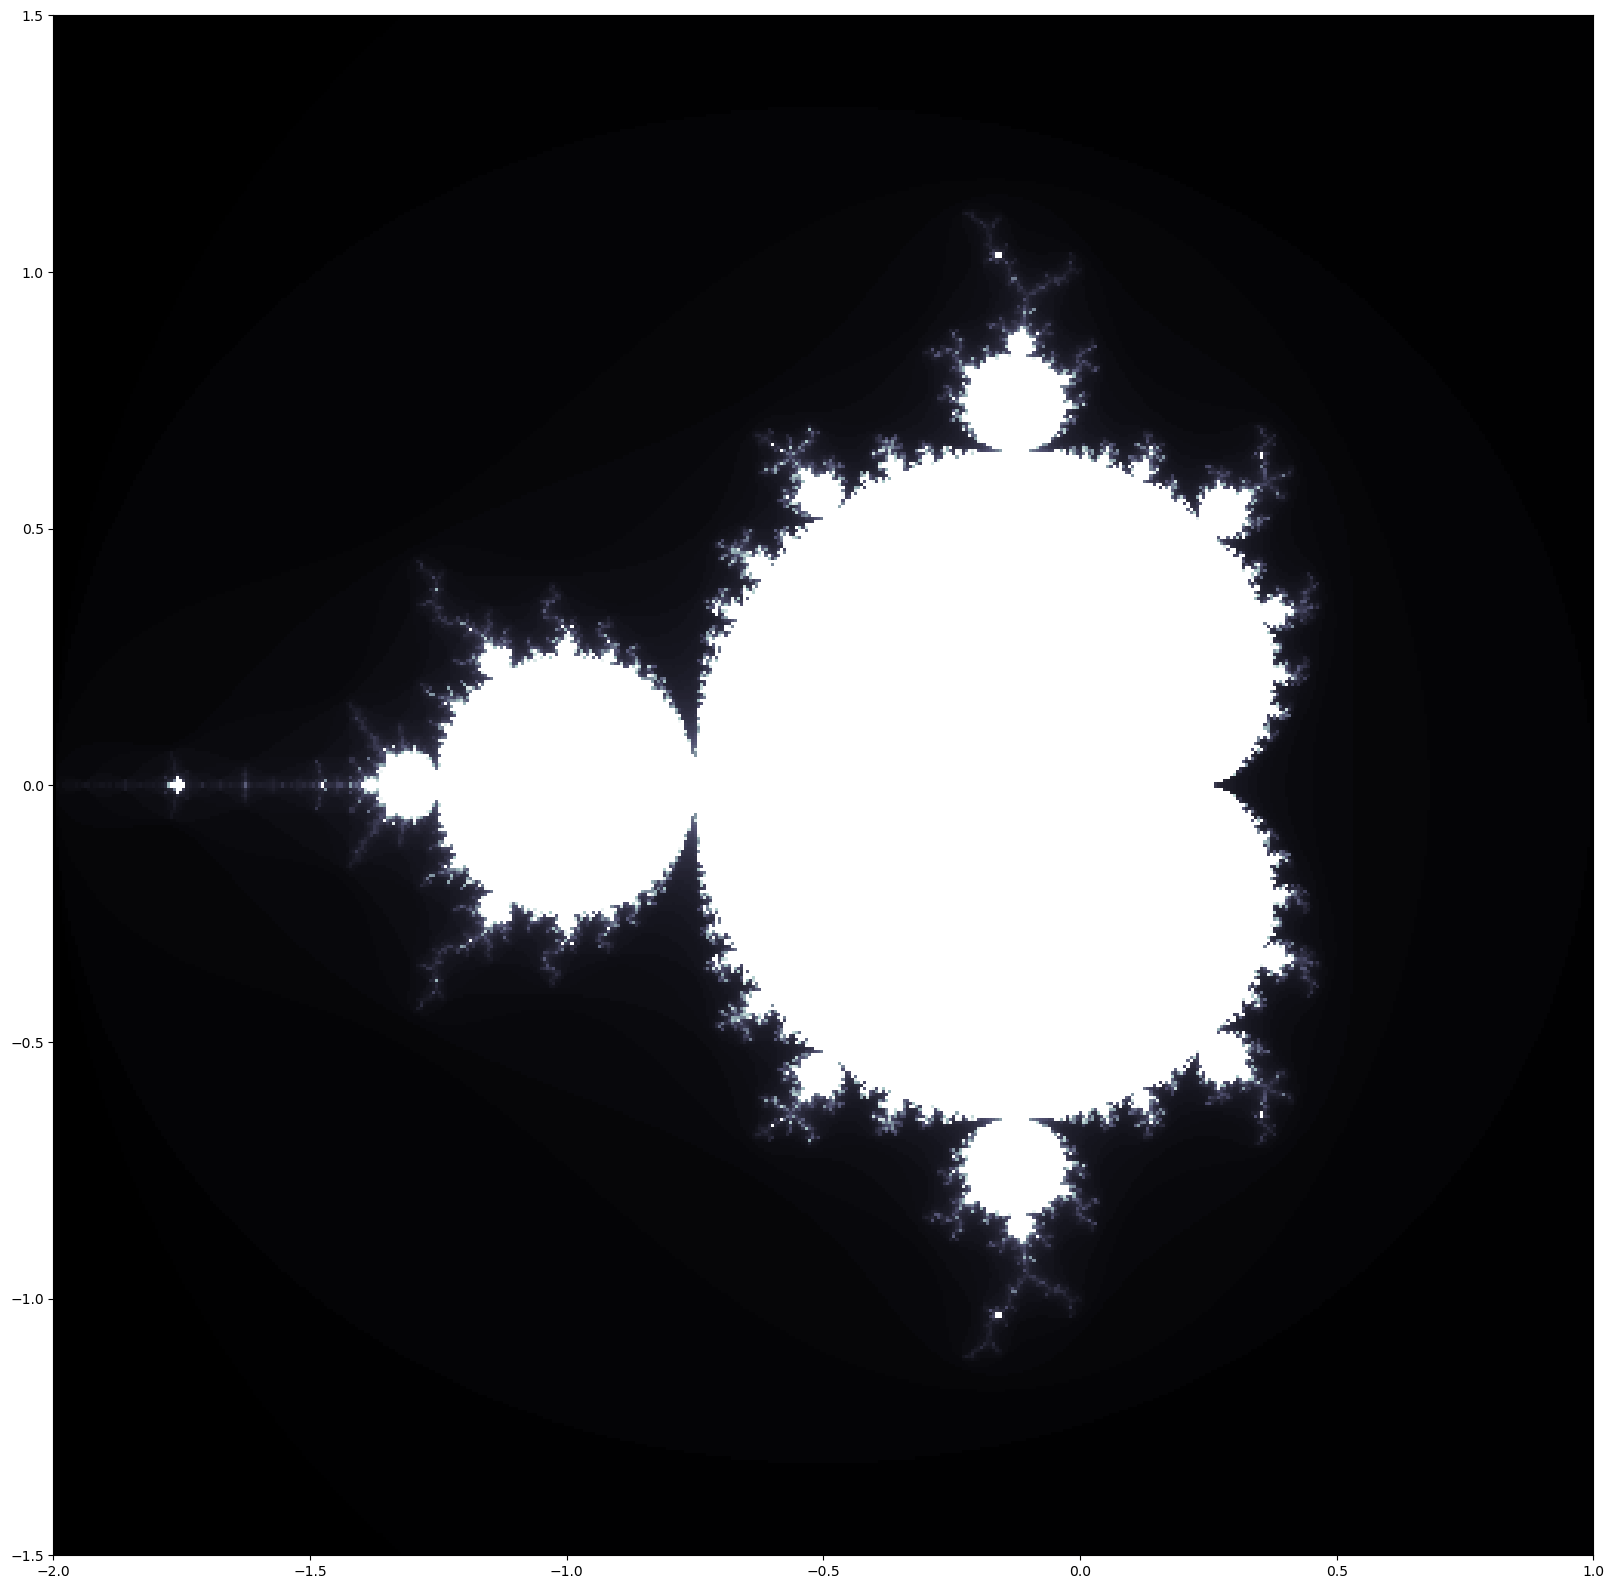

In [150]:
M = data

ploterino.imshow(M, cmap='bone', extent=(-2, 1, -1.5, 1.5))
ploterino.rcParams["figure.figsize"] = [20, 20]
ploterino.rcParams["figure.dpi"] = 100
ploterino.show()